In [9]:
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
from yahoo_finance import Share
from googlefinance import getQuotes
import urllib.request as urlopen
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
mpl.rcParams['figure.figsize'] = (14, 8)
today = str(datetime.datetime.now().date())
#mpl.rc("figure.figsize",(14,8))

In [5]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)    
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=tableau20) 
plt.rc('grid', linestyle="--", color='black',alpha = 0.5)

In [8]:
Quote = 'HM-B.ST'
yahoo = Share(Quote)
print(yahoo.get_historical('2016-04-25', '2016-05-29'))

#CHECK IF DATA EXISTS
hist_data[-1]

YQLResponseMalformedError: Response malformed.

In [ ]:
df = pd.DataFrame(hist_data)
df['Date'] = pd.to_datetime(df.Date)
df = df.groupby(['Date']).sum()
df = df.loc[:, df.columns != 'Symbol'].astype(float)
#df.columns = df.columns.swaplevel(0, 1)
df.info()
df.head()

In [259]:
#PCT CHANGE
df['pct_open_close_change'] = (df['Close']/df['Open']-1)*100
df['pct_low_high_change'] = (df['High']/df['Low']-1)*100
df['pct_open_high_change'] = (df['High']/df['Open']-1)*100
df['pct_close_open_change'] = (df['Open']/df['Close'].shift(periods=1)-1)*100
df['pct_close_close_change'] = (df['Close']/df['Close'].shift(periods=1)-1)*100
df['pct_open_close_change_yesterday'] = (df['Open'].shift(periods=1)/df['Close'].shift(periods=1)-1)*100
#ROLLING
df['rolling_20'] = df['Close'].rolling(window = 20).mean()
df['rolling_40'] = df['Close'].rolling(window = 40).mean()
df['rolling_80'] = df['Close'].rolling(window = 80).mean()
df['rolling_160'] = df['Close'].rolling(window = 160).mean()
#OTHER
df['over_under'] = (df['Close']/df['rolling_20']-1)*100
df['upday'] = df['pct_open_close_change']>0.01
df['pct_open_close_change_round'] = df['pct_open_close_change'].round()
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
#df['pct_change_incl_close_change'] = (df['Close']/df['close-1']-1)*100
df.head(5)

,Adj_Close,Close,High,Low,Open,Volume,pct_open_close_change,pct_low_high_change,pct_open_high_change,pct_close_open_change,pct_close_close_change,pct_open_close_change_yesterday,rolling_20,rolling_40,rolling_80,rolling_160,over_under,upday,pct_open_close_change_round,is_train
Date,,,,,,,,,,,,,,,,,,,,
2015-04-24,34.5,34.5,40.0,32.5,38.0,9614900.0,-9.210526,23.076923,5.263158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,-9.0,True
2015-04-27,39.0,39.0,39.4,34.7,35.0,2337200.0,11.428571,13.544669,12.571429,1.449275,13.043478,10.144928,NaN,NaN,NaN,NaN,NaN,True,11.0,False
2015-04-28,38.8,38.8,40.7,38.1,39.9,1391800.0,-2.756892,6.824147,2.005013,2.307692,-0.512821,-10.256410,NaN,NaN,NaN,NaN,NaN,False,-3.0,False
2015-04-29,38.0,38.0,39.3,36.6,39.3,887700.0,-3.307888,7.377049,0.000000,1.288660,-2.061856,2.835052,NaN,NaN,NaN,NaN,NaN,False,-3.0,True
2015-04-30,36.6,36.6,38.3,36.6,38.1,379400.0,-3.937008,4.644809,0.524934,0.263158,-3.684211,3.421053,NaN,NaN,NaN,NaN,NaN,False,-4.0,False


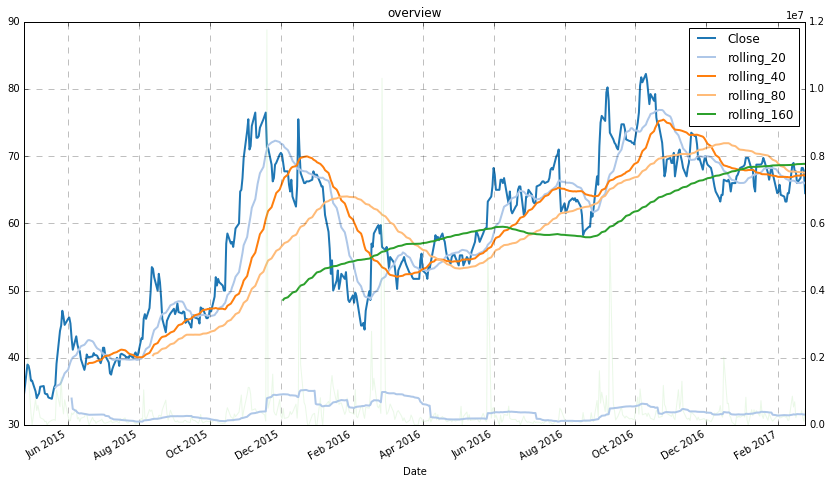

In [262]:
f, ax = plt.subplots(1,1)
df[['Close','rolling_20','rolling_40','rolling_80','rolling_160']].plot(ax=ax, lw=2,title='overview')
df['Volume'].plot(ax=ax,lw=1,ls='-',alpha=0.2,secondary_y=True)
df['Volume'].rolling(30).mean().plot(ax=ax,lw=2,ls='-',alpha=1,secondary_y=True,color=tableau20[1])
ax.grid(True)

In [265]:
# Add number of negative days
df['neg_days'] = np.nan
df['pos_days'] = np.nan
neg_days = 0
pos_days = 0
for index, row in df.iterrows():
    df.set_value(index,'neg_days',neg_days)
    df.set_value(index,'pos_days',pos_days)
    if row['pct_close_close_change']<0:
        neg_days = neg_days+1
        pos_days = 0
    elif row['pct_close_close_change']>0:
        pos_days = pos_days+1
        neg_days = 0
    else:
        neg_days = 0
        pos_days = 0
df.head()

,Adj_Close,Close,High,Low,Open,Volume,pct_open_close_change,pct_low_high_change,pct_open_high_change,pct_close_open_change,...,rolling_20,rolling_40,rolling_80,rolling_160,over_under,upday,pct_open_close_change_round,is_train,neg_days,pos_days
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-24,34.5,34.5,40.0,32.5,38.0,9614900.0,-9.210526,23.076923,5.263158,NaN,...,NaN,NaN,NaN,NaN,NaN,False,-9.0,True,0.0,0.0
2015-04-27,39.0,39.0,39.4,34.7,35.0,2337200.0,11.428571,13.544669,12.571429,1.449275,...,NaN,NaN,NaN,NaN,NaN,True,11.0,False,0.0,0.0
2015-04-28,38.8,38.8,40.7,38.1,39.9,1391800.0,-2.756892,6.824147,2.005013,2.307692,...,NaN,NaN,NaN,NaN,NaN,False,-3.0,False,0.0,1.0
2015-04-29,38.0,38.0,39.3,36.6,39.3,887700.0,-3.307888,7.377049,0.000000,1.288660,...,NaN,NaN,NaN,NaN,NaN,False,-3.0,True,1.0,0.0
2015-04-30,36.6,36.6,38.3,36.6,38.1,379400.0,-3.937008,4.644809,0.524934,0.263158,...,NaN,NaN,NaN,NaN,NaN,False,-4.0,False,2.0,0.0


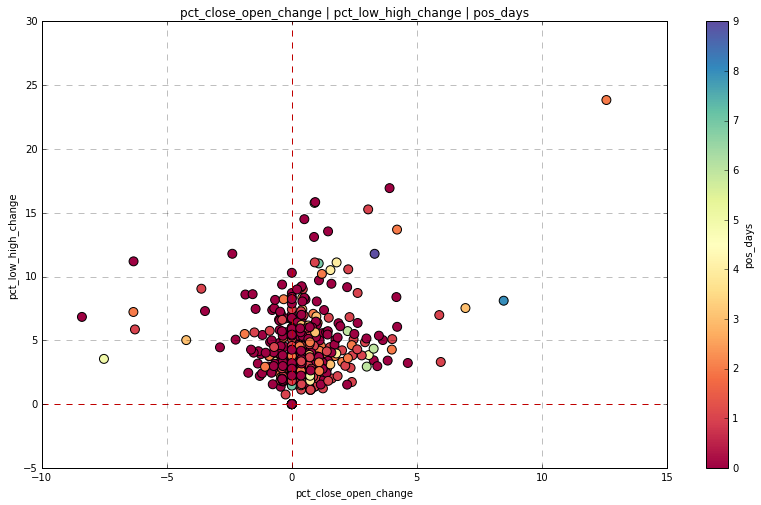

In [266]:
# CLose price change dependancy
f, ax = plt.subplots(1,1)
cmap = mpl.cm.get_cmap('Spectral')
x = 'pct_close_open_change'
y = 'pct_low_high_change'
c = 'pos_days'
df[abs(df['pct_close_open_change'])<40].plot(ax=ax,kind='scatter',x=x,y=y,c=c,grid=True,s=80,cmap=cmap,title=x+' | '+y+' | '+c)
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')

### Doji

In [232]:
def doji(open,close,high,low):
    delta = 0.001
    d_t = 0.003
    lld_t = 0.01
    gd_t = 0.02
    dd_t = 0.02
    if (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+lld_t)*open) & (low<=(1-lld_t)*close):
        print('LONG LEGGED DOJI!')
        return 'll_doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+d_t)*open) & (low<=(1-d_t)*close):
        print('DOJI!')
        return 'doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (high>=(1+gd_t)*open) & (low<=(1+delta)*close) & (low>=(1-delta)*close):
        print('GRAVESTONE DOJI!')
        return 'g_doji'
    elif (close<=open*(1+delta)) & (close>=open*(1-delta)) & (low<=(1-dd_t)*open) & (high<=(1+delta)*close) & (high>=(1-delta)*close):
        print('DRAGONFLY DOJI!')
        return 'd_doji'
    else:
        return 'no_doji'

In [233]:
df.head()

,Adj_Close,Close,High,Low,Open,Volume,pct_open_close_change,pct_low_high_change,pct_open_high_change,pct_close_open_change,pct_close_close_change,pct_open_close_change_yesterday,rolling_20,rolling_40,over_under,upday,pct_open_close_change_round,is_train,neg_days,pos_days
Date,,,,,,,,,,,,,,,,,,,,
2014-01-01,30.3962,30.3962,30.3962,30.3962,30.3962,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,True,0.0,0.0
2014-01-02,30.6233,30.6233,30.9089,30.3230,30.7038,753300.0,-0.262183,1.932197,0.667995,1.011969,0.747133,0.000000,NaN,NaN,NaN,False,-0.0,True,0.0,0.0
2014-01-03,30.5427,30.5427,30.7991,30.3450,30.6306,463900.0,-0.286968,1.496457,0.550103,0.023838,-0.263198,0.262872,NaN,NaN,NaN,False,-0.0,True,0.0,1.0
2014-01-06,30.5427,30.5427,30.5427,30.5427,30.5427,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.287794,NaN,NaN,NaN,False,0.0,True,1.0,0.0
2014-01-07,30.3230,30.3230,30.7112,30.3230,30.6892,502100.0,-1.193254,1.280216,0.071686,0.479656,-0.719321,0.000000,NaN,NaN,NaN,False,-1.0,True,0.0,0.0


In [234]:
df['doji'] = df.apply(lambda row: doji(row['Open'],row['Close'],row['High'],row['Low']), axis = 1)
df.head()

DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
LONG LEGGED DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
DOJI!
LONG LEGGED DOJI!
DOJI!
LONG LEGGED DOJI!
DOJI!
DOJI!
LONG LEGGED DOJI!
LONG LEGGED DOJI!


,Adj_Close,Close,High,Low,Open,Volume,pct_open_close_change,pct_low_high_change,pct_open_high_change,pct_close_open_change,...,pct_open_close_change_yesterday,rolling_20,rolling_40,over_under,upday,pct_open_close_change_round,is_train,neg_days,pos_days,doji
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,30.3962,30.3962,30.3962,30.3962,30.3962,0.0,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,False,0.0,True,0.0,0.0,no_doji
2014-01-02,30.6233,30.6233,30.9089,30.3230,30.7038,753300.0,-0.262183,1.932197,0.667995,1.011969,...,0.000000,NaN,NaN,NaN,False,-0.0,True,0.0,0.0,no_doji
2014-01-03,30.5427,30.5427,30.7991,30.3450,30.6306,463900.0,-0.286968,1.496457,0.550103,0.023838,...,0.262872,NaN,NaN,NaN,False,-0.0,True,0.0,1.0,no_doji
2014-01-06,30.5427,30.5427,30.5427,30.5427,30.5427,0.0,0.000000,0.000000,0.000000,0.000000,...,0.287794,NaN,NaN,NaN,False,0.0,True,1.0,0.0,no_doji
2014-01-07,30.3230,30.3230,30.7112,30.3230,30.6892,502100.0,-1.193254,1.280216,0.071686,0.479656,...,0.000000,NaN,NaN,NaN,False,-1.0,True,0.0,0.0,no_doji


In [235]:
df_doji = df['doji'][df['doji']!='no_doji'].reset_index()
#df_doji = df_doji.reset_index(level=1).rename(columns={'dt':'date'}).reset_index().rename(columns={'dt':'time'})
df_doji.head()

,Date,doji
0,2014-01-13,doji
1,2014-02-18,doji
2,2014-02-27,doji
3,2014-03-20,doji
4,2014-03-25,doji


In [236]:
#df['High'].loc[row['Date']]

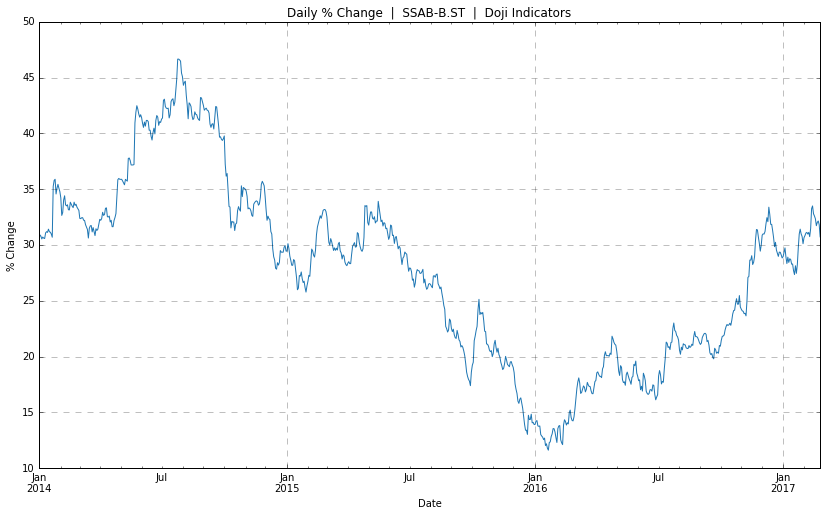

In [237]:
fig, ax = plt.subplots(1,1)
#df_daily_norm.loc[:,'high'].plot(ax = ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote))
ax.set_xlabel('Time')
ax.set_ylabel('% Change')
#print(df_daily_norm[df_doji[0,'time']])
df['High'].plot(ax=ax,legend=False,grid='on',title='Daily % Change  |  '+str(Quote)+'  |  Doji Indicators')
for index, row in df_doji.iterrows():
    ax.plot(row['Date'], df['High'].loc[row['Date']], 'o')
    #ax.text(row['Date'], df['High'].loc[row['Date']], row['doji'])

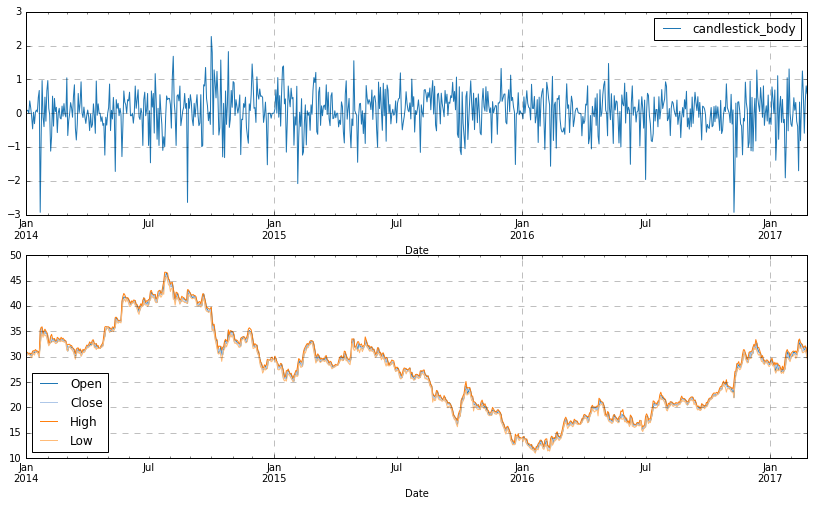

In [238]:
fig, ax = plt.subplots(2,1)
df['Spread'] = df['High'] - df['Low']
df['candlestick_body'] = df['Open'] - df['Close']
df['candlestick_body'].plot(ax=ax[0], legend=True,grid ='on')
#df['High'].plot(ax=ax[0], grid ='on', legend = True)
df[['Open','Close','High','Low']].plot(ax=ax[1], grid ='on', legend = True)
#.plot(secondary_y='volume')

### Random Forrest

In [239]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
print(df.columns)
features = ['neg_days','pos_days','over_under','pct_close_open_change']
pred_y = 'upday'

Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'pct_open_close_change', 'pct_low_high_change', 'pct_open_high_change',
       'pct_close_open_change', 'pct_close_close_change',
       'pct_open_close_change_yesterday', 'rolling_20', 'rolling_40',
       'over_under', 'upday', 'pct_open_close_change_round', 'is_train',
       'neg_days', 'pos_days', 'doji', 'Spread', 'candlestick_body'],
      dtype='object')


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 823 entries, 2014-01-01 to 2017-02-24
Data columns (total 23 columns):
Adj_Close                          823 non-null float64
Close                              823 non-null float64
High                               823 non-null float64
Low                                823 non-null float64
Open                               823 non-null float64
Volume                             823 non-null float64
pct_open_close_change              823 non-null float64
pct_low_high_change                823 non-null float64
pct_open_high_change               823 non-null float64
pct_close_open_change              822 non-null float64
pct_close_close_change             822 non-null float64
pct_open_close_change_yesterday    822 non-null float64
rolling_20                         804 non-null float64
rolling_40                         784 non-null float64
over_under                         804 non-null float64
upday                              8

In [241]:
df_f = df.dropna()
train, test = df_f[df_f['is_train']==True], df_f[df_f['is_train']==False]
clf = RandomForestClassifier()
clf.fit(train[features], train[pred_y])
preds = clf.predict(test[features])
pd.crosstab(test[pred_y], preds, rownames=['actual'], colnames=['preds'])

preds,False,True
actual,,
False,86,33
True,42,35


In [242]:
rf = RandomForestRegressor()
rf.fit(train[features], train[pred_y])
print(rf.feature_importances_)
print(features)

[ 0.09317928  0.06933891  0.48811818  0.34936363]
['neg_days', 'pos_days', 'over_under', 'pct_close_open_change']


In [56]:
(~df['is_train']).sum()

85